# Logistic Regression Sentiment Classifier for Twitter Political Data   
This notebook explains in details various steps implemented for a Logistic Regression classifier. The steps we've taken have been broken into stages (represented as `<stage number> - <stage name>`).

# 1 - Getting Started
In this stage, we:

a. Install and import all dependencies required for the challenge.

b. Initialize Spark Session.

c. Read and cache dataset.

In [1]:
import matplotlib.pyplot as plt
!pip install textblob


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
%matplotlib inline 
from src.jobs.spark_etl import extract
from src.utils.spark import initSparkSession
from src.utils.dataset import getPolarity
from src.transforms.Preprocessing import CleanTweet, polarityCalculator
from sklearn.preprocessing import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, NGram, VectorAssembler, SQLTransformer, HashingTF, IDF, StringIndexer, ChiSqSelector
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit

In [3]:
# Spark Session for ETL job
sparkSession = initSparkSession(appName='Preprocessing')
sparkSession

24/05/12 19:36:00 WARN Utils: Your hostname, Abels-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.247.203.189 instead (on interface en0)
24/05/12 19:36:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/12 19:36:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/12 19:36:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/05/12 19:36:00 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/05/12 19:36:00 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
24/05/12 19:36:00 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
24/05/12 19:36:00 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attemp

In [4]:
df = extract(sparkSession)
df_train, df_test = df.randomSplit([0.70, 0.30], seed=123456) 
df_train.cache()
df_test.cache()

DataFrame[created_at: timestamp, tweet_id: string, tweet: string, likes: float, retweet_count: float, source: string, user_id: string, user_name: string, user_screen_name: string, user_description: string, user_join_date: timestamp, user_followers_count: float, user_location: string, lat: double, long: double, city: string, country: string, continent: string, state: string, state_code: string, collected_at: timestamp, candidate: string]

In [5]:
df.createOrReplaceTempView("politicalTweets")
df.printSchema()

root
 |-- created_at: timestamp (nullable = true)
 |-- tweet_id: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- likes: float (nullable = true)
 |-- retweet_count: float (nullable = true)
 |-- source: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_join_date: timestamp (nullable = true)
 |-- user_followers_count: float (nullable = true)
 |-- user_location: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- state: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- collected_at: timestamp (nullable = true)
 |-- candidate: string (nullable = false)



# 2 - Spark User Defined Function (UDF)
In this stage, we implement an UDF for labelling our dataset using a rule-based algorithm. 

In [6]:
polarity = sparkSession.udf.register('Polarity', lambda record: getPolarity(record))

# 3 - Pipelines
In this stage, we experiment with different pipeline configurations (stages in the pipeline) to analyze which gives us the best results.    

## 3.1 - Pipeline using HashingTF

In [7]:
def pipelineModelHashtf():
    cleanTweet = CleanTweet()
    regexTokenizer = RegexTokenizer(inputCol="cleaned_tweet", outputCol="cleaned_tweet_words", pattern="[^a-zA-Z0-9_#]")
    stopWordsRemover = StopWordsRemover(inputCol='cleaned_tweet_words', outputCol='cleaned_tweet_nostop')
    polarityCalc = polarityCalculator()
    hashTF = HashingTF(inputCol="cleaned_tweet_nostop", outputCol='tf')
    idf = IDF(inputCol='tf', outputCol="features")
    sentimentStringIdx = StringIndexer(inputCol = "polarity", outputCol = "label")
    logisticRegression = LogisticRegression()  # defaulted to featuresCol='features', labelCol='label'

    dataCleaningStages = [cleanTweet, regexTokenizer, stopWordsRemover]
    featureLabelMapStages = [hashTF, idf, sentimentStringIdx]
    
    return Pipeline(stages=dataCleaningStages+[polarityCalc]+featureLabelMapStages+[logisticRegression]), logisticRegression
    
    
pipeline, _ = pipelineModelHashtf()
pipelineModel = pipeline.fit(df_train)
predictions = pipelineModel.transform(df_test)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

24/05/12 19:36:14 WARN MemoryStore: Not enough space to cache rdd_11_0 in memory! (computed 262.6 MiB so far)
24/05/12 19:36:14 WARN BlockManager: Persisting block rdd_11_0 to disk instead.
24/05/12 19:36:16 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
24/05/12 19:36:23 WARN MemoryStore: Not enough space to cache rdd_11_0 in memory! (computed 150.6 MiB so far)
24/05/12 19:36:25 WARN MemoryStore: Not enough space to cache rdd_11_0 in memory! (computed 150.6 MiB so far)
24/05/12 19:36:27 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/05/12 19:36:28 WARN MemoryStore: Not enough space to cache rdd_11_0 in memory! (computed 150.6 MiB so far)
24/05/12 19:36:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/12 19:36:29 

Accuracy: 0.7813121272365805
Precision: 0.7825628548867444
Recall: 0.7813121272365805


## 3.2 - Pipeline using CountVectorizer

In [8]:
def pipelineCv():
    cleanTweet = CleanTweet()
    regexTokenizer = RegexTokenizer(inputCol="cleaned_tweet", outputCol="cleaned_tweet_words", pattern="[^a-zA-Z0-9_#]")
    stopWordsRemover = StopWordsRemover(inputCol='cleaned_tweet_words', outputCol='cleaned_tweet_nostop')
    polarityCalc = polarityCalculator()
    countVectorizer = CountVectorizer(inputCol='cleaned_tweet_nostop', outputCol='cv')
    idf = IDF(inputCol='cv', outputCol="features")
    sentimentStringIdx = StringIndexer(inputCol = "polarity", outputCol = "label")
    logisticRegression = LogisticRegression()  # defaulted to featuresCol='features', labelCol='label'

    dataCleaningStages = [cleanTweet, regexTokenizer, stopWordsRemover]
    featureLabelMapStages = [countVectorizer, idf, sentimentStringIdx]
    
    return Pipeline(stages=dataCleaningStages+[polarityCalc]+featureLabelMapStages+[logisticRegression]), logisticRegression

In [9]:
pipeline, _ = pipelineCv()
pipelineModel = pipeline.fit(df_train)
predictions = pipelineModel.transform(df_test)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

24/05/12 19:36:57 WARN MemoryStore: Not enough space to cache rdd_11_1 in memory! (computed 158.9 MiB so far)
24/05/12 19:36:58 WARN MemoryStore: Not enough space to cache rdd_11_1 in memory! (computed 158.9 MiB so far)
24/05/12 19:36:59 WARN MemoryStore: Not enough space to cache rdd_11_1 in memory! (computed 158.9 MiB so far)
24/05/12 19:37:01 WARN MemoryStore: Not enough space to cache rdd_11_1 in memory! (computed 158.9 MiB so far)
24/05/12 19:37:02 WARN MemoryStore: Not enough space to cache rdd_11_1 in memory! (computed 158.9 MiB so far)
24/05/12 19:37:05 WARN DAGScheduler: Broadcasting large task binary with size 1419.8 KiB
24/05/12 19:37:06 WARN DAGScheduler: Broadcasting large task binary with size 1419.8 KiB
24/05/12 19:37:06 WARN DAGScheduler: Broadcasting large task binary with size 1419.8 KiB
24/05/12 19:37:07 WARN DAGScheduler: Broadcasting large task binary with size 1419.8 KiB


Accuracy: 0.7883607446231701
F1 Score: 0.7874754652554263
Precision: 0.7886848168264928
Recall: 0.78836074462317


# 4 - Fine-tuning
In this stage, we experiment with cross-validation and the lesser expensive train-validation split for fine-tuning our models. 

## 4.1 Cross-Validation

In [10]:
# 10-fold cross-validation
pipeline, logisticRegression = pipelineCv()

paramGrid = ParamGridBuilder() \
    .addGrid(logisticRegression.maxIter, [100, 200, 300, 500, 800]) \
    .addGrid(logisticRegression.regParam, [0.1, 0.01]) \
    .build()

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
crossVal = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10, seed=123456)
crossValModel = crossVal.fit(df_train)
predictions = crossValModel.transform(df_test)
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

24/05/12 19:37:10 WARN MemoryStore: Not enough space to cache rdd_341_0 in memory! (computed 154.1 MiB so far)
24/05/12 19:37:10 WARN BlockManager: Persisting block rdd_341_0 to disk instead.
24/05/12 19:37:14 WARN MemoryStore: Not enough space to cache rdd_341_1 in memory! (computed 160.7 MiB so far)
24/05/12 19:37:14 WARN BlockManager: Persisting block rdd_341_1 to disk instead.
24/05/12 19:37:16 WARN MemoryStore: Not enough space to cache rdd_341_0 in memory! (computed 249.6 MiB so far)
24/05/12 19:37:17 WARN MemoryStore: Not enough space to cache rdd_341_0 in memory! (computed 249.6 MiB so far)
24/05/12 19:37:17 WARN MemoryStore: Not enough space to cache rdd_341_0 in memory! (computed 249.6 MiB so far)
24/05/12 19:37:19 WARN MemoryStore: Not enough space to cache rdd_341_0 in memory! (computed 249.6 MiB so far)
24/05/12 19:37:20 WARN MemoryStore: Not enough space to cache rdd_341_0 in memory! (computed 249.6 MiB so far)
24/05/12 19:37:25 WARN MemoryStore: Not enough space to cache

Accuracy: 0.7941442255557564
F1 Score: 0.789483321201123
Precision: 0.7937925198368496
Recall: 0.7941442255557563


In [11]:
bestPipelineModel = crossValModel.bestModel
bestModel = bestPipelineModel.stages[-1]
bestParams = bestModel.extractParamMap()
# crossValModel.getEstimatorParamMaps()[np.argmax(crossValModel.avgMetrics)]

In [12]:
bestModelCoeff = bestModel.coefficientMatrix
bestModelCoeff

DenseMatrix(3, 25315, [0.0245, 0.0406, 0.0119, -0.0261, -0.0311, 0.0754, 0.0184, -0.0609, ..., -0.0594, 0.028, -0.0497, -0.0018, 0.3788, 0.1128, -0.0034, -0.0252], 1)

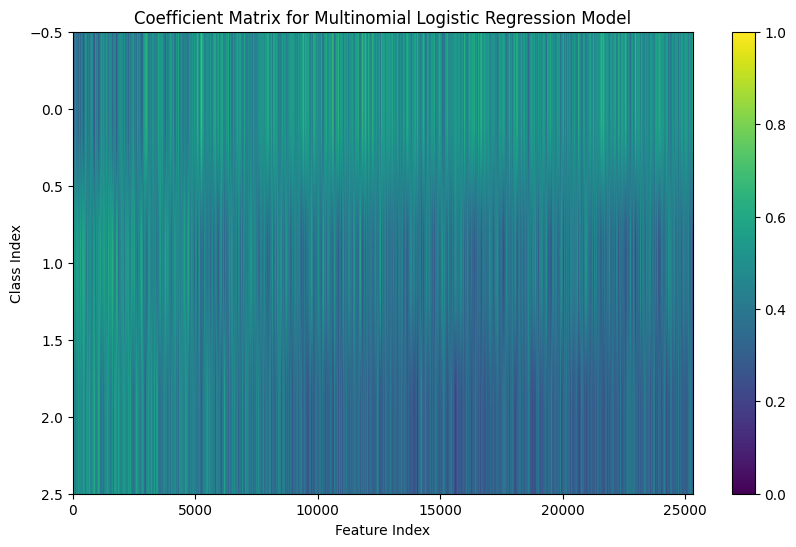

In [13]:
bestModelCoeffArr = bestModelCoeff.toArray()
minMaxScalar = MinMaxScaler()
bestModelCoeffArrNormalized = minMaxScalar.fit_transform(bestModelCoeffArr)

plt.figure(figsize=(10, 6))
plt.imshow(bestModelCoeffArrNormalized, cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel('Feature Index')
plt.ylabel('Class Index')
plt.title('Coefficient Matrix for Multinomial Logistic Regression Model')
plt.show()

## 4.2 Train-Validation Split

In [14]:
# using Train Validation Split
pipeline, _ = pipelineCv()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

trainValidationSplit = TrainValidationSplit(
    estimator=pipeline
    ,estimatorParamMaps=paramGrid
    ,evaluator=evaluator
    ,trainRatio=0.8
    ,seed=123456
)
trainValidationSplitModel = trainValidationSplit.fit(df_train)
predictions = trainValidationSplitModel.transform(df_test)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

24/05/12 19:51:40 WARN MemoryStore: Not enough space to cache rdd_14953_0 in memory! (computed 156.6 MiB so far)
24/05/12 19:51:40 WARN BlockManager: Persisting block rdd_14953_0 to disk instead.
24/05/12 19:51:44 WARN MemoryStore: Not enough space to cache rdd_14953_1 in memory! (computed 163.1 MiB so far)
24/05/12 19:51:44 WARN BlockManager: Persisting block rdd_14953_1 to disk instead.
24/05/12 19:51:52 WARN MemoryStore: Not enough space to cache rdd_11_1 in memory! (computed 158.9 MiB so far)
24/05/12 19:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1294.9 KiB
24/05/12 19:51:53 WARN MemoryStore: Not enough space to cache rdd_14953_1 in memory! (computed 163.1 MiB so far)
24/05/12 19:51:54 WARN MemoryStore: Not enough space to cache rdd_14953_1 in memory! (computed 163.1 MiB so far)
24/05/12 19:51:55 WARN MemoryStore: Not enough space to cache rdd_14953_1 in memory! (computed 163.1 MiB so far)
24/05/12 19:51:56 WARN MemoryStore: Not enough space to cache rdd_1495

Accuracy: 0.7883607446231701
F1 Score: 0.7874754652554263
Precision: 0.7886848168264928
Recall: 0.78836074462317


In [15]:
sparkSession.stop()